# Import

In [1]:
from ucimlrepo import fetch_ucirepo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import rand_score, fowlkes_mallows_score, jaccard_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer

# Data

In [2]:
wine_quality = fetch_ucirepo(id=186)

X = wine_quality.data.original.drop(['quality'], axis=1)
y = wine_quality.data.targets

In [3]:
X.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'color'],
      dtype='object')

# Preprocess then PCA

In [4]:
columntransformer = ColumnTransformer(
    [
        ('standardscaler', QuantileTransformer(), [col for col in X.columns if 'color' not in col]),
        ('ohe', OneHotEncoder(sparse_output=False), ['color']),
    ],
    remainder='passthrough'
).set_output(transform='pandas')

pl = Pipeline(
    [
        ('columntransformer', columntransformer),
        ('dim_red', PCA(n_components=2))
    ]
).set_output(transform='pandas')

X_pca2 = pl.fit_transform(X, y)
X_pca2

,pca0,pca1
0,1.459614,-0.013781
1,1.367388,-0.203733
2,1.434478,-0.103723
3,1.208650,-0.291206
4,1.459614,-0.013781
...,...,...
6492,-0.397345,0.686383
6493,-0.552275,-0.400987
6494,-0.446822,0.240550
6495,-0.498490,1.041453


## Reduction to 2-Dimensions

<Axes: xlabel='pca0', ylabel='pca1'>

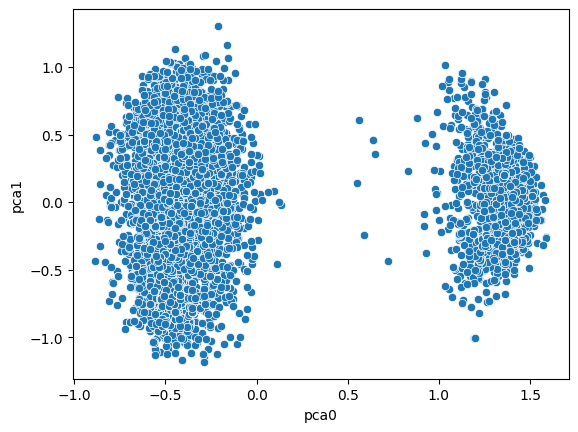

In [5]:
sns.scatterplot(X_pca2, x=X_pca2.columns[0], y=X_pca2.columns[1])

## Clustered according to quality

<Axes: xlabel='pca0', ylabel='pca1'>

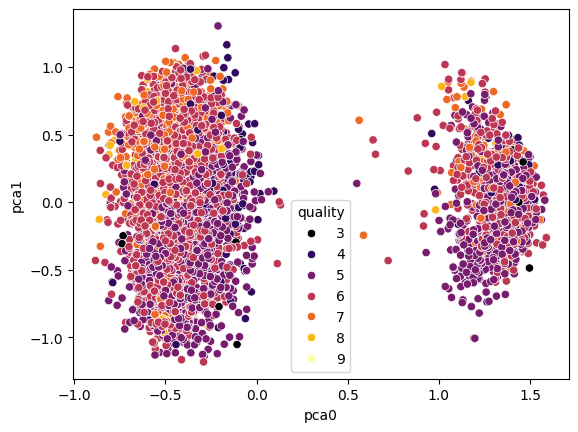

In [6]:
combined_1 = pd.concat([X_pca2, y], axis=1)
sns.scatterplot(combined_1, x=combined_1.columns[0], y=combined_1.columns[1], hue='quality', palette='inferno')

<Axes: xlabel='pca0', ylabel='pca1'>

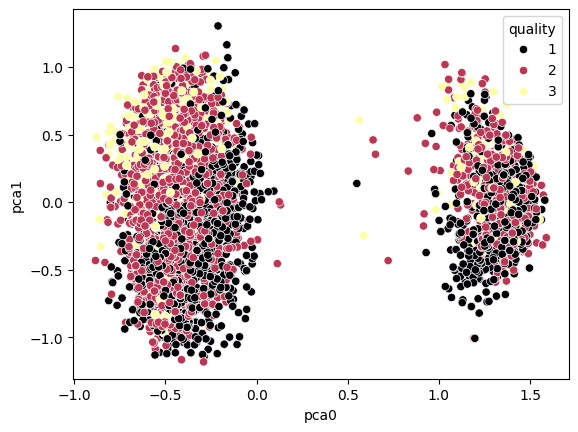

In [7]:
y_tri = y.map(lambda x: 1 if x in [3, 4, 5] else 2 if x in [6] else 3 if x in [7, 8, 9] else 0)
combined_2 = pd.concat([X_pca2, y_tri], axis=1)
sns.scatterplot(combined_2, x=combined_2.columns[0], y=combined_2.columns[1], hue='quality', palette='inferno')

# KMeans

## Visualization of Cluster

<Axes: xlabel='pca0', ylabel='pca1'>

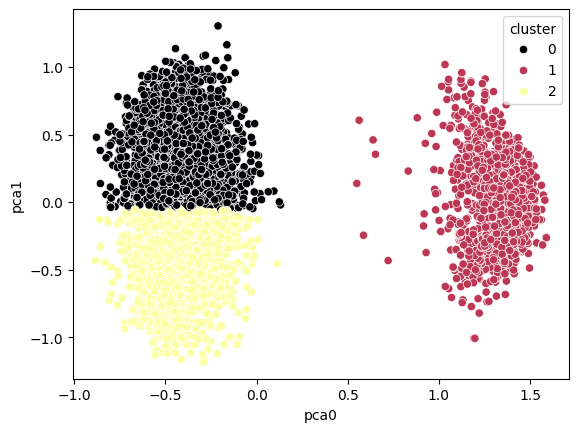

In [8]:
clusterer = KMeans(n_clusters=3, n_init='auto', random_state=42).set_output(transform='pandas')
clusterer.fit(X_pca2)
labels_pred = pd.DataFrame(clusterer.labels_.reshape(-1, 1), columns=['cluster'])
combined_with_cluster = pd.concat([X_pca2, labels_pred], axis=1)
sns.scatterplot(combined_with_cluster, x=combined_with_cluster.columns[0], y=combined_with_cluster.columns[1], hue='cluster', palette='inferno')

## Metrics

In [9]:
kmeans_rand_score = rand_score(y_tri.squeeze(), labels_pred.squeeze())
kmeans_rand_score

0.5547707316222493

In [10]:
kmeans_fowlkes_mallows_score = fowlkes_mallows_score(y_tri.squeeze(), labels_pred.squeeze())
kmeans_fowlkes_mallows_score

0.3758442453294021

In [11]:
kmeans_jaccard_score = jaccard_score(y_tri.squeeze(), labels_pred.squeeze(), average='weighted')
kmeans_jaccard_score

0.1845198204471425

# (Clusterer 2)

## Visualization of Cluster

<Axes: xlabel='pca0', ylabel='pca1'>

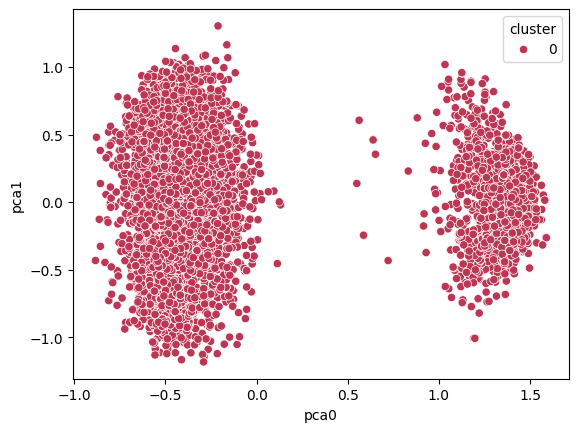

In [12]:
clusterer = DBSCAN()
clusterer.fit(X_pca2)
labels_pred = pd.DataFrame(clusterer.labels_.reshape(-1, 1), columns=['cluster'])
combined_with_cluster = pd.concat([X_pca2, labels_pred], axis=1)
sns.scatterplot(combined_with_cluster, x=combined_with_cluster.columns[0], y=combined_with_cluster.columns[1], hue='cluster', palette='inferno')

## Metrics

In [13]:
dbscan_rand_score = rand_score(y_tri.squeeze(), labels_pred.squeeze())
dbscan_rand_score

0.36371902606053114

In [14]:
dbscan_fowlkes_mallows_score = fowlkes_mallows_score(y_tri.squeeze(), labels_pred.squeeze())
dbscan_fowlkes_mallows_score

0.6030912253221159

In [15]:
dbscan_jaccard_score = jaccard_score(y_tri.squeeze(), labels_pred.squeeze(), average='weighted')
dbscan_jaccard_score

0.0

# Summary

In [16]:
summary = pd.DataFrame(
    {
        'KMeans': [kmeans_rand_score, kmeans_fowlkes_mallows_score, kmeans_jaccard_score],
        'DBSCAN': [dbscan_rand_score,dbscan_fowlkes_mallows_score,dbscan_jaccard_score],
    },
    index=['rand_score', 'fowlkes_mallows_score', 'jaccard_score']
)
summary

,KMeans,DBSCAN
rand_score,0.554771,0.363719
fowlkes_mallows_score,0.375844,0.603091
jaccard_score,0.184520,0.000000


In [17]:
pl['dim_red'].explained_variance_ratio_.cumsum()

array([0.45318601, 0.62273578])

Based on the visualization, PCA on the preprocessed data had a poor performance on explained variance to 2 dimensions as the cumulative explained variance ratio was only at ~60%. Hence the visualization for clustering based on quality was very poor. This poor performance can also be reflected on the scores of the comparison between actual clusters per quality and clusters from KMeans and DBSCAN.

However, although the quality as a cluster was not properly captured, color as cluster is very much captured.

<Axes: xlabel='pca0', ylabel='pca1'>

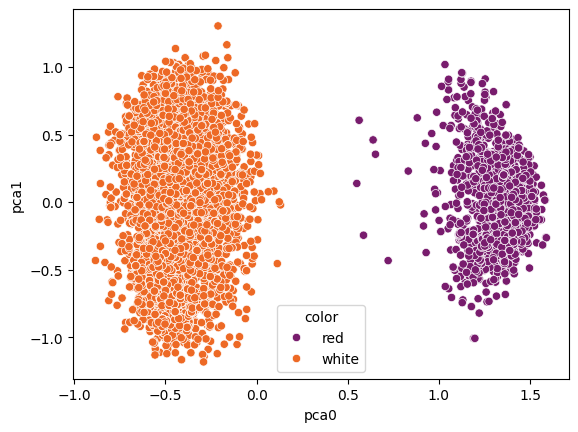

In [18]:
combined_1 = pd.concat([X_pca2, y, X['color']], axis=1)
sns.scatterplot(combined_1, x=combined_1.columns[0], y=combined_1.columns[1], hue='color', palette='inferno')